# IVOL Puzzle & Arbitrage Asymmetry

This project aims to study the relationship between idiosyncratic volatility and expected return on equities. It attempts to recreate the study done by Stambaugh et al in 2015, with updated dataset up to 2024.

Idiosyncratic volatility is defined as the volatility of residuals when historical returns are regressed against Fama-French 3 factors. In line with Stambaugh's approach, we calculate IVOL over a historical period of one month. This yields a time series of IVOL values for each stock in our universe. 

At the same time, we use a composite, cross sectional measure for mispricing based on 10 return anomalies (the financial distress score is not easily retrievable). Each return anomaly is a time series object for each stock in our universe. To arrive at a composite measure for each time stamp, for each return anomaly, we rank each stock by the return anomaly. This yields 10 different rankings for each stock on any given day. We take the arithmetic mean of the 10 rankings to be the composite cross sectional measure of mispricing. 

With IVOL and mispricing measure, for each date, we sort stocks on IVOL and mispricing, grouping into 5 groups along each dimension. This forms 25 different baskets of stocks. We form each into a value-weighted portfolio. We then calculate the return on this portfolio for the next month, and regress against fama-french 3 factors to find the return that survive factor adjustment. 




## Notebook Set Up

In [11]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import seaborn as sns
import wrds
import statsmodels.api as sm
from scipy.stats import percentileofscore

plt.style.use('seaborn-v0_8-notebook')
eps = 1e-8
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

conn = wrds.Connection()
start = "1965-01-01"
end = "2025-01-01"

Loading library list...
Done


## Security identification
In line with Stambaugh et al's methodology, we use all NYSE/AMex/NASDAQ stocks with share prices greater than five dollars. We expand the dataset to cover up to 2024.

The code used to extract all tickers from the three relevant exchanges was 

```python
tickers = conn.raw_sql(
    f"""
    SELECT permno, ticker, namedt
    FROM crsp.msenames
    WHERE namedt BETWEEN '{start}' AND '{end}'
    AND exchcd in (1, 2, 3)
    """
)
```

From documentation, we understand that PERMNO is a unique five-digit permanent identifier assigned by CRSP to each security in the file. Unlike CUSIP, TICKER, and COMNAM, the PERMNO neither changes during an issue's trading history, nor is reassigned after an issue ceases trading. The user may track a security through its entire trading history in CRSP's files with one PERMNO, regardless of name changes or capital structure changes. A security that is included on both CRSP's Nasdaq and NYSE/AMEX files will have the same CRSP permanent number in both files.

Therefore, we have elected to work with `permnos` when identifying securities, instead of using individual tickers


## IVOL calculation

To calculate idiosyncratic volatility, we retrieved daily FF 3 factors. 

```python
factors = conn.raw_sql(
    f"""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.factors_daily
    WHERE date BETWEEN '{start}' AND '{end}'
    """,
    date_cols = ['date']
).set_index('date')

factors = (
    factors.replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)
```

We want a time-series at month-end frequency for each security in our universe, where `ivol_df.loc[t, p]` refers to the volatility of the residuals after regressing the daily returns for security `p` for month `t` against FF 3 factors. 

```python
ivol_df = pd.DataFrame(
    index = month_end_dates,
    columns = tickers['permno'].unique()
)

for i, permno in enumerate(ivol_df.columns[:100]):
    ret_df = (
        conn.raw_sql(
        f"""
        SELECT date, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{start}' AND '{end}'
        AND permno = {permno}
        """,
        date_cols = ['date'])
        .set_index('date')
        .merge(
            factors,
            left_index=True,
            right_index=True,
            how='left'
        )
    )
    ret_df['ex_ret'] = ret_df['ret'] - ret_df['rf']

    for idx in ivol_df.index:
        time_range_mask = (
            (ret_df.index >= idx - pd.DateOffset(months = 1)) * (ret_df.index <= idx)
        )
        X = np.asarray(
            ret_df[['mktrf', 'smb', 'hml']][time_range_mask]
        )
        y = np.asarray(
            ret_df[['ex_ret']][time_range_mask]
        )

        if X.shape[0] != 0:
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            ivol = np.std(
                model.resid
            )
            ivol_df.loc[idx, col] = ivol


ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
```

## IVOL EDA

In [9]:
ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df.columns = ivol_df.columns.astype(int)
ivol_df

,83264,63618,10896,69906,79030,11233,44127,86580,91786,88837,...,56120,31713,85792,83586,89403,81454,79163,86036,92970,19812
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.011945,NaN,NaN,NaN,NaN,NaN,NaN,0.025849,0.009253,0.013778,...,NaN,NaN,0.015452,NaN,0.018388,NaN,NaN,NaN,NaN,0.042034
2024-09-30,0.010587,NaN,NaN,NaN,NaN,NaN,NaN,0.011175,0.011429,0.010877,...,NaN,NaN,0.012494,NaN,0.010137,NaN,NaN,NaN,NaN,0.162169
2024-10-31,0.007728,NaN,NaN,NaN,NaN,NaN,NaN,0.016819,0.010310,0.047612,...,NaN,NaN,0.008540,NaN,0.009744,NaN,NaN,NaN,NaN,0.045123
2024-11-30,0.008987,NaN,NaN,NaN,NaN,NaN,NaN,0.017378,0.012528,0.048934,...,NaN,NaN,0.010319,NaN,0.024362,NaN,NaN,NaN,NaN,0.108532


We visualize the IVOL for Apple, Microsoft and Intuitive Surgical.

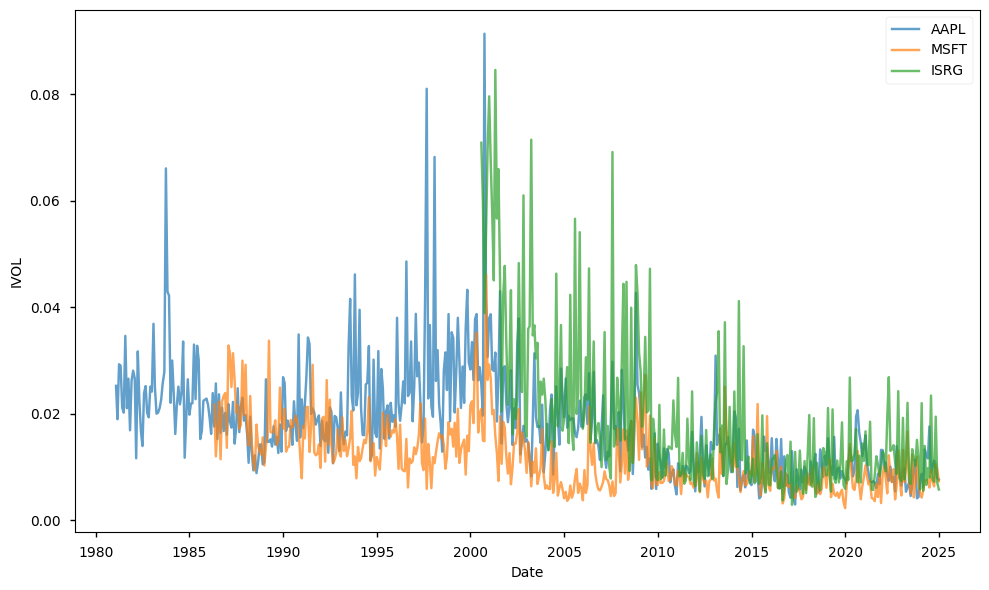

In [5]:
tickers = ['AAPL', 'MSFT', 'ISRG']
tickers_permno_map = conn.raw_sql(
    f"""
    SELECT DISTINCT permno, ticker
    FROM crsp.msenames
    WHERE ticker in ({','.join(["'" + t + "'" for t in tickers])})
    """
)
tickers_permno_map

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

for ticker in tickers:
    permno = tickers_permno_map[
        tickers_permno_map['ticker'] == ticker
    ]['permno'].iloc[0]
    ax.plot(
        ivol_df[str(permno)],
        label = ticker,
        alpha = .7
    )

ax.set_xlabel('Date')
ax.set_ylabel('IVOL')
ax.legend()

plt.tight_layout()
plt.show()

We visualize the aggregate IVOL across all securities.

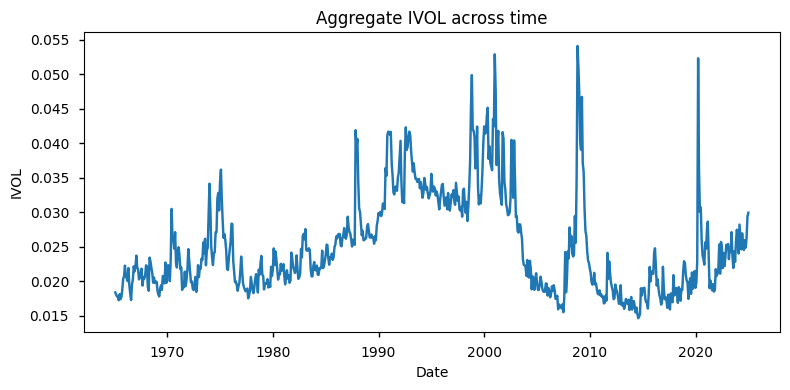

In [7]:
ivol_by_date = ivol_df.apply(lambda x: x.mean(), axis = 1)

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(
    ivol_by_date
)
ax.set_xlabel('Date')
ax.set_ylabel('IVOL')

ax.set_title("Aggregate IVOL across time")

plt.tight_layout()
plt.show()

We visualize the IVOL for 10 randomly picked securities.

Text(0.5, 1.0, '10 randomly picked IVOLs')

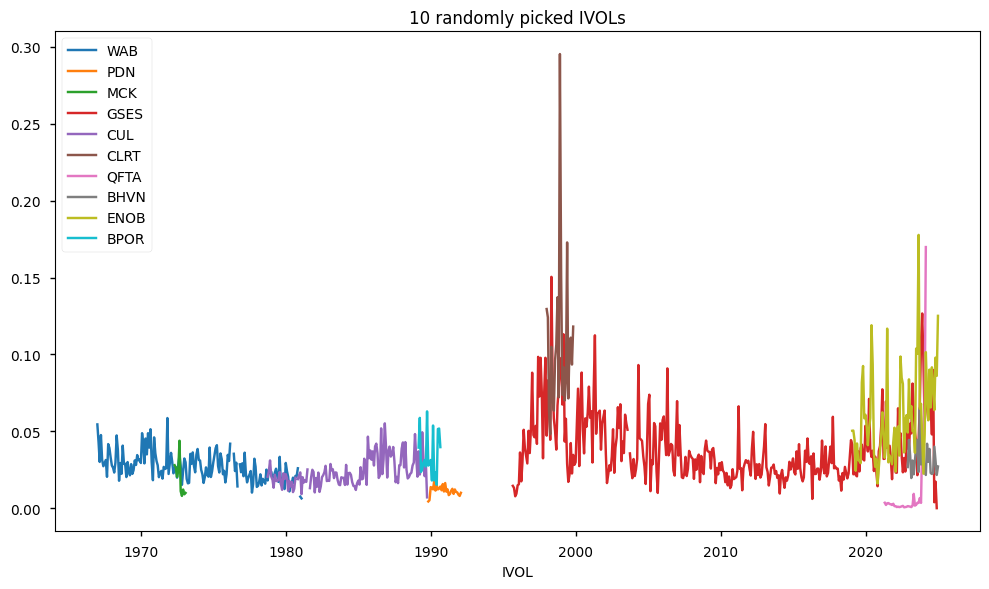

In [8]:
fig, ax = plt.subplots(1, 1)
for rng_col in np.random.randint(0, ivol_df.shape[1], size = 10):
    ticker = conn.raw_sql(
        f"""
            SELECT DISTINCT ticker
            FROM crsp.msenames
            WHERE permno = {ivol_df.columns[rng_col]}
        """
    )['ticker'][0]
    ax.plot(
        ivol_df.iloc[:, rng_col],
        label = ticker
    )
ax.set_xlabel('Date')
ax.set_xlabel('IVOL')
ax.legend()
ax.set_title("10 randomly picked IVOLs")

## IVOL Long Short Strategy

We consider a LS strategy where we long the 10% lowest IVOL stocks every month, and short the 10% highest IVOL stocks every month. If there is truly a negative IVOL effect on expected return, this strategy should generate excess returns. 

In [10]:
quantile_low = 0.10
quantile_high = 0.90

long_short_dict = {}

for date, row in ivol_df.iterrows():
    print("======" * 10)
    ivol_today = row.dropna()

    prices = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date =  '{date.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    ).set_index('permno')
    if prices.shape[0] == 0:
        prices = conn.raw_sql(
            f"""
                SELECT DISTINCT ON (permno) permno, prc, date
                FROM crsp.msf
                WHERE date <= '{date.strftime("%Y-%m-%d")}'
                ORDER BY permno, date DESC
            """
        )

        prices = prices[prices['prc']>=5].set_index("permno")

    ivol_filtered = ivol_today[ivol_today.index.isin(prices.index)]
    
    if len(ivol_filtered) < 10:
        print(f"Skipping {date},  not enough tradeable securities")
        continue

    low_thresh = ivol_filtered.quantile(quantile_low)
    high_thresh = ivol_filtered.quantile(quantile_high)
    print(f"low threshold: {low_thresh:.4f}, high threshold: {high_thresh:.4f}")

    long_stocks = ivol_filtered[ivol_filtered <= low_thresh].index.tolist()
    short_stocks = ivol_filtered[ivol_filtered >= high_thresh].index.tolist()

    print(
        f"long leg mean IVOL: {ivol_df.loc[date, long_stocks].mean():.4f}"
    )
    print(
        f"short leg mean IVOL: {ivol_df.loc[date, short_stocks].mean():.4f}"
    )

    print(f"Processed {date}, {len(ivol_filtered)} total, {len(long_stocks)} longs, {len(short_stocks)} shorts")

    long_short_dict[date] = {
        'long': long_stocks,
        'short': short_stocks
    }


ls_returns = []

for date, positions in long_short_dict.items():
    next_month = (date + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")

    tickers = positions['long'] + positions['short']

    ret_data = conn.raw_sql(
        f"""
        SELECT permno, ret
        FROM crsp.msf
        WHERE date = '{next_month}'
        """
    )

    long_returns = ret_data[ret_data['permno'].isin(positions['long'])]['ret']
    short_returns = ret_data[ret_data['permno'].isin(positions['short'])]['ret']

    if len(long_returns) == 0 or len(short_returns) == 0:
        continue

    # we work with equal-weighted portfolio for now
    long_ret = long_returns.mean()
    short_ret = short_returns.mean()

    ls_return = long_ret - short_ret

    ls_returns.append({
        'date': date,
        'long_ret': long_ret,
        'short_ret': short_ret,
        'ls_ret': ls_return
    })
    print(f"Processed {date}, LS return: {ls_return}")

ls_df = pd.DataFrame(ls_returns).set_index('date')

low threshold: 0.0067, high threshold: 0.0258
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0349
Processed 1965-01-31 00:00:00, 1471 total, 148 longs, 148 shorts
low threshold: 0.0068, high threshold: 0.0267
long leg mean IVOL: 0.0057
short leg mean IVOL: 0.0352
Processed 1965-02-28 00:00:00, 1488 total, 149 longs, 149 shorts
low threshold: 0.0064, high threshold: 0.0264
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0346
Processed 1965-03-31 00:00:00, 1469 total, 147 longs, 147 shorts
low threshold: 0.0064, high threshold: 0.0263
long leg mean IVOL: 0.0053
short leg mean IVOL: 0.0345
Processed 1965-04-30 00:00:00, 1526 total, 153 longs, 153 shorts
low threshold: 0.0065, high threshold: 0.0254
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0343
Processed 1965-05-31 00:00:00, 1487 total, 149 longs, 149 shorts
low threshold: 0.0081, high threshold: 0.0244
long leg mean IVOL: 0.0068
short leg mean IVOL: 0.0314
Processed 1965-06-30 00:00:00, 1512 total, 152 longs, 152 shorts
low 

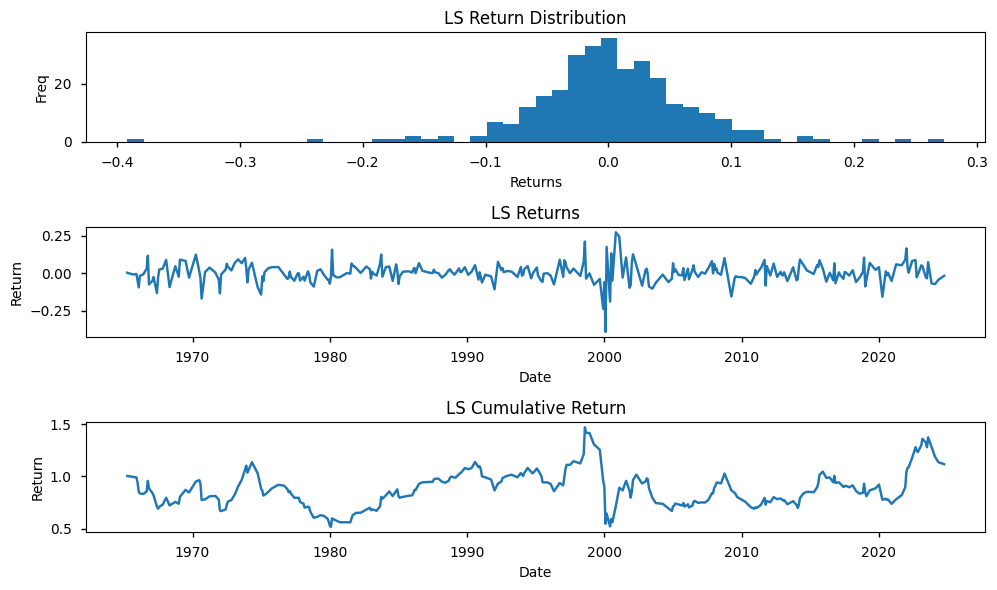

Text(0.5, 1.0, 'Cumulative Return')

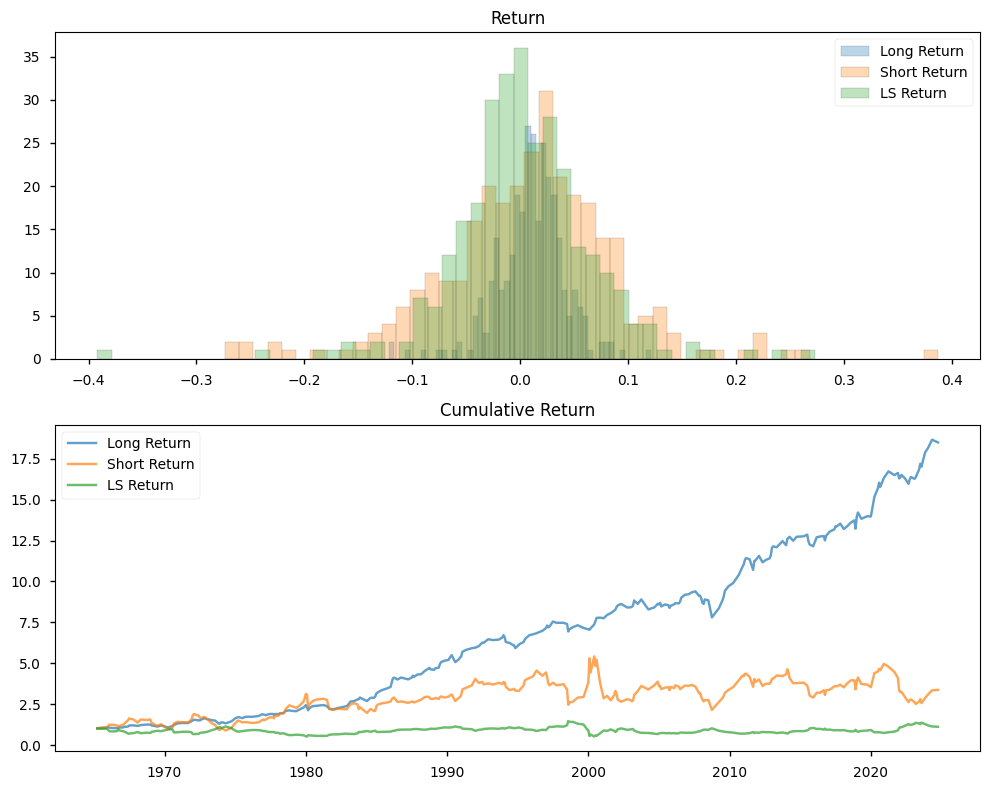

In [43]:
fig, axes = plt.subplots(3, 1, figsize= (10, 6))
axes[0].hist(
    ls_df['ls_ret'],
    bins = 50,
)

axes[0].set_xlabel("Returns")
axes[0].set_ylabel("Freq")

axes[1].plot(
    ls_df['ls_ret']
)

axes[1].set_xlabel("Date")
axes[1].set_ylabel("Return")
axes[1].set_title("LS Returns")

axes[2].plot(
    (ls_df['ls_ret'] + 1).cumprod()
)

axes[2].set_xlabel("Date")
axes[2].set_ylabel("Return")

axes[0].set_title("LS Return Distribution")
axes[2].set_title("LS Cumulative Return")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 1, figsize = (10, 8))

axes[0].hist(
    ls_df['long_ret'],
    label = "Long Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].hist(
    ls_df['short_ret'],
    label = "Short Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].hist(
    ls_df['ls_ret'],
    label = "LS Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].legend()

axes[0].set_title("Return")

axes[1].plot(
    (ls_df['long_ret'] + 1).cumprod(),
    label = "Long Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['short_ret'] + 1).cumprod(),
    label = "Short Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['ls_ret'] + 1).cumprod(),
    label = "LS Return",
    alpha = .7
)

axes[1].legend()
axes[1].set_title("Cumulative Return")


In [12]:
factors = (
    conn.raw_sql(
        f"""
        SELECT date, mktrf, smb, hml, rf
        FROM ff.factors_daily
        WHERE date BETWEEN '{start}' AND '{end}'
        """,
        date_cols = ['date']
    )
    .set_index('date')
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

ls_df = ls_df.merge(
    factors,
    left_index = True,
    right_index = True
)

y = np.asarray(ls_df['ls_ret'] - ls_df['rf'])
X = np.asarray(
    ls_df[['mktrf', 'smb', 'hml']]
)
X = sm.add_constant(X)

res = sm.OLS(y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.644
Date:                Mon, 21 Apr 2025   Prob (F-statistic):              0.179
Time:                        11:53:52   Log-Likelihood:                 395.74
No. Observations:                 302   AIC:                            -783.5
Df Residuals:                     298   BIC:                            -768.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.004      0.384      0.701      -0.006       0.009
x1             0.7307      0.399      1.831      0.068      -0.055       1.516
x2             0.7158      0.634      1.129      0.260      -0.532       1.963
x3            -0.2500      0.731     -0.342      0.732      -1.688       1.188
==============================================================================
Omnibus:                       50.763   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.885
Skew:                          -0.408   Prob(JB):                     5.26e-78
Kurtosis:                       8.255   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TODO: add write up on IVOL LS strategy return

## Retrieving return anomalies

The 9 return anomalies are retrieved in a separate notebook.

## Generating aggregate mispricing measure

To generate the aggregate mispricing measure, we follow Stambaugh et al's methodology. For each return anomaly, we rank all securities for which the anomaly can be calculated. 

For each date, for each anomaly, we sort all stocks from most underpiced to most overpriced. After assigning percentile rankings to each stock for each return anomaly, we filter for stocks that have at least 5 return anomalies that can be calculated. The overall aggregate mispricing measure is the arithmetic mean of the individual return anomaly scores.

In [12]:
anomalies_df = pd.read_csv('./Data/anomalies_raw_new.csv')
anomalies_df

,date,variable,10003,10007,10010,10016,10017,10021,10027,10031,...,93371,93374,93384,93390,93392,93395,93397,93427,93428,93435
0,1965-01-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1965-02-28,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1965-03-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1965-04-30,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1965-05-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2024-08-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125307,0.018117,NaN,NaN,NaN,NaN,0.453436,0.371898,NaN,NaN
8636,2024-09-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.686486,0.159861,NaN,NaN,NaN,NaN,0.663626,0.462309,NaN,NaN
8637,2024-10-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.321839,0.328630,NaN,NaN,NaN,NaN,0.874680,0.525419,NaN,NaN
8638,2024-11-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.093846,0.114412,NaN,NaN,NaN,NaN,0.710237,0.488388,NaN,NaN


In [15]:
anomalies_df.set_index(['date', 'variable'], inplace=True)
anomalies_df.columns = anomalies_df.columns.astype(int)

columns_to_reverse = [
    'niq_at', # return on assets
    'ret_12_1', # momentum
    'gp_at'
]

for idx in anomalies_df.index:
    var = idx[1]
    if var in columns_to_reverse:
        anomalies_df.loc[idx] = - anomalies_df.loc[idx]

anomalies_pct = pd.DataFrame(
    index = anomalies_df.index,
    columns = anomalies_df.columns
)
for i, idx in enumerate(anomalies_pct.index):
    print(f"Processing {i} out of {anomalies_pct.shape[0]}")
    anomalies_pct.loc[idx] = anomalies_df.loc[idx].rank(pct=True)

Processing 0 out of 8640
Processing 1 out of 8640
Processing 2 out of 8640
Processing 3 out of 8640
Processing 4 out of 8640
Processing 5 out of 8640
Processing 6 out of 8640
Processing 7 out of 8640
Processing 8 out of 8640
Processing 9 out of 8640
Processing 10 out of 8640
Processing 11 out of 8640
Processing 12 out of 8640
Processing 13 out of 8640
Processing 14 out of 8640
Processing 15 out of 8640
Processing 16 out of 8640
Processing 17 out of 8640
Processing 18 out of 8640
Processing 19 out of 8640
Processing 20 out of 8640
Processing 21 out of 8640
Processing 22 out of 8640
Processing 23 out of 8640
Processing 24 out of 8640
Processing 25 out of 8640
Processing 26 out of 8640
Processing 27 out of 8640
Processing 28 out of 8640
Processing 29 out of 8640
Processing 30 out of 8640
Processing 31 out of 8640
Processing 32 out of 8640
Processing 33 out of 8640
Processing 34 out of 8640
Processing 35 out of 8640
Processing 36 out of 8640
Processing 37 out of 8640
Processing 38 out of 8

In [ ]:
aggregated = {}

for i, stock in enumerate(anomalies_pct.columns):
    print(f"Processing column {i}/{anomalies_pct.shape[1]}", end = '\r')
    temp = (
        anomalies_pct[stock]
        .unstack('variable') 
        .apply(lambda row: row.dropna().mean() if row.dropna().shape[0] >= 5 else np.nan, axis=1)
    )
    aggregated[stock] = temp

aggregate_mispricing_df = pd.concat(aggregated, axis=1)
aggregate_mispricing_df.index = pd.to_datetime(aggregate_mispricing_df.index)

In [21]:
aggregate_mispricing_df.to_csv('./Data/aggregate_mispricing.csv')

## Double sorting stocks on IVOL and mispricing

The next section intends to form 25 value-weighted portfolio of stocks double sorted on IVOL and mispricing measure. 

Along each dimension, we split our stocks into 5 quintiles. The naming scheme of our portfolio is as follows
- each security gets assigned a label 0-4 for mispricing, where 0 is the most overpriced and 4 is the most underpriced, let this be $l1$
- each security gets assigned a label 0-4 for IVOL, where 0 is the lowest IVOL and 4 is the highest IVOL,  let this be $l2$

The overall portfolio that each ticker falls under will be $k$
$$
k = 5 \times l1 + l2
$$

#### Sorting on IVOL

Since we previously calculated IVOLs for all securities, regardless of whether they meet our $5 trading price requirement, we want to filter these out. The filtering was done when we processed the return anomalies and mispricing measures, hence the difference in shape between `ivol_df` and `aggregate_mispricing_df`.

In [22]:
ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df.columns = ivol_df.columns.astype(int)

filtered_cols = ivol_df.columns[
    ivol_df.columns.isin(aggregate_mispricing_df.columns)
]

ivol_df = ivol_df[filtered_cols]
ivol_df

,83264,63618,69906,79030,11233,44127,86580,91786,88837,88451,...,66480,56120,85792,83586,89403,81454,79163,86036,92970,19812
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.011945,NaN,NaN,NaN,NaN,NaN,0.025849,0.009253,0.013778,NaN,...,NaN,NaN,0.015452,NaN,0.018388,NaN,NaN,NaN,NaN,0.042034
2024-09-30,0.010587,NaN,NaN,NaN,NaN,NaN,0.011175,0.011429,0.010877,NaN,...,NaN,NaN,0.012494,NaN,0.010137,NaN,NaN,NaN,NaN,0.162169
2024-10-31,0.007728,NaN,NaN,NaN,NaN,NaN,0.016819,0.010310,0.047612,NaN,...,NaN,NaN,0.008540,NaN,0.009744,NaN,NaN,NaN,NaN,0.045123
2024-11-30,0.008987,NaN,NaN,NaN,NaN,NaN,0.017378,0.012528,0.048934,NaN,...,NaN,NaN,0.010319,NaN,0.024362,NaN,NaN,NaN,NaN,0.108532


In [31]:
def map_quantile(x, quantiles):
    if x <= quantiles[0]:
        return 0
    elif x <= quantiles[1]:
        return 1
    elif x <= quantiles[2]:
        return 2
    elif x <= quantiles[3]:
        return 3
    else:
        return 4

def map_quantile_reversed(x, quantiles):
    if x <= quantiles[0]:
        return 4
    elif x <= quantiles[1]:
        return 3
    elif x <= quantiles[2]:
        return 2
    elif x <= quantiles[3]:
        return 1
    else:
        return 0
    
ivol_quintiles = pd.DataFrame(index=ivol_df.index, columns=ivol_df.columns)
mispricing_quintiles = pd.DataFrame(index=aggregate_mispricing_df.index, 
                                    columns=aggregate_mispricing_df.columns)


for idx in ivol_df.index:

    permnos = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date = '{idx.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    )

    if permnos.shape[0] == 0:
        permnos = conn.raw_sql(
            f"""
            SELECT DISTINCT ON (permno) permno, prc, date
            FROM crsp.msf
            WHERE date <= '{idx.strftime("%Y-%m-%d")}'
            ORDER BY permno, date DESC
            """
        )
        permnos = permnos[permnos['prc'].abs() >= 5]
    
    valid_permnos = ivol_df.columns[ivol_df.columns.isin(permnos['permno'])]

    print(f"Processing {idx} - {len(valid_permnos)} permnos ranked")

    ivol_today = ivol_df.loc[idx, valid_permnos].dropna()
    quantiles = np.quantile(ivol_today, [0.2, 0.4, 0.6, 0.8])
    ranked = ivol_today.apply(lambda x: map_quantile(x, quantiles))
    ivol_quintiles.loc[idx, ranked.index] = ranked

    mispricing_t = aggregate_mispricing_df.loc[idx, valid_permnos].dropna()
    quantiles = np.quantile(mispricing_t, [0.2, 0.4, 0.6, 0.8])
    ranked = mispricing_t.apply(lambda x: map_quantile_reversed(x, quantiles))
    mispricing_quintiles.loc[idx, ranked.index] = ranked


Processing 1965-01-31 00:00:00 - 1581 permnos ranked
Processing 1965-02-28 00:00:00 - 1606 permnos ranked
Processing 1965-03-31 00:00:00 - 1485 permnos ranked
Processing 1965-04-30 00:00:00 - 1547 permnos ranked
Processing 1965-05-31 00:00:00 - 1635 permnos ranked
Processing 1965-06-30 00:00:00 - 1539 permnos ranked
Processing 1965-07-31 00:00:00 - 1636 permnos ranked
Processing 1965-08-31 00:00:00 - 1531 permnos ranked
Processing 1965-09-30 00:00:00 - 1545 permnos ranked
Processing 1965-10-31 00:00:00 - 1685 permnos ranked
Processing 1965-11-30 00:00:00 - 1621 permnos ranked
Processing 1965-12-31 00:00:00 - 1661 permnos ranked
Processing 1966-01-31 00:00:00 - 1672 permnos ranked
Processing 1966-02-28 00:00:00 - 1714 permnos ranked
Processing 1966-03-31 00:00:00 - 1665 permnos ranked
Processing 1966-04-30 00:00:00 - 1776 permnos ranked
Processing 1966-05-31 00:00:00 - 1646 permnos ranked
Processing 1966-06-30 00:00:00 - 1646 permnos ranked
Processing 1966-07-31 00:00:00 - 1783 permnos 

In [32]:
ivol_quintiles.to_csv('./Data/ivol_quintiles.csv')
mispricing_quintiles.to_csv('./Data/mispricing_quintiles.csv')

In [35]:
mispricing_aligned = mispricing_quintiles.reindex(columns=ivol_quintiles.columns)

portfolio_allocation = 5 * mispricing_aligned + ivol_quintiles

In [36]:
portfolio_allocation

,83264,63618,69906,79030,11233,44127,86580,91786,88837,88451,...,66480,56120,85792,83586,89403,81454,79163,86036,92970,19812
date,,,,,,,,,,,,,,,,,,,,,
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,2,NaN,NaN,NaN,NaN,NaN,14,21,7,NaN,...,NaN,NaN,3,NaN,13,NaN,NaN,NaN,NaN,NaN
2024-09-30,2,NaN,NaN,NaN,NaN,NaN,12,22,17,NaN,...,NaN,NaN,2,NaN,17,NaN,NaN,NaN,NaN,NaN
2024-10-31,1,NaN,NaN,NaN,NaN,NaN,13,22,9,NaN,...,NaN,NaN,6,NaN,21,NaN,NaN,NaN,NaN,NaN


After creating the 25 portfolios, now we value-weight them and calculate the return on each of the 25 portfolios.

In [63]:
source_df = pd.read_csv(
    './Data/me_prc_ret.csv',
)
source_df['date'] = pd.to_datetime(source_df['date'])
source_df

KeyError: 'date'

In [45]:
source_df = pd.read_csv(
    './Data/me_prc_ret.csv',
)
source_df['date'] = pd.to_datetime(source_df['date'])


market_equity_df = source_df[
    source_df['variable'] == 'me'
].drop(columns='variable').set_index('date')
prc_df = source_df[
    source_df['variable'] == 'me'
].drop(columns='variable').set_index('date')

ret_df = source_df[
    source_df['variable'] == 'ret'
].drop(columns='variable').set_index('date')


In [41]:
portfolio_comp = pd.DataFrame(
    columns= np.arange(25),
    index = pd.date_range(
        '1965-01-01',
        '2025-01-01',
        freq = 'ME'
    )
)

for date in portfolio_comp.index:
    for portfolio in portfolio_comp.columns:
        portfolio_comp.loc[date, portfolio] = np.asarray(portfolio_allocation.columns[
            portfolio_allocation.loc[date] == portfolio
        ])

portfolio_comp

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1965-01-31,"[20626, 19377, 15624, 21792, 12183, 18956, 217...","[23851, 33873, 24985, 25056, 27473, 12650, 161...","[26550, 27377, 10161, 28150, 40635, 26059, 244...","[27596, 21274, 32707, 39108, 40360, 36003, 319...","[40694, 30525, 31616, 29049, 26673, 27633, 325...","[22840, 21573, 25953, 16512, 12431, 17742, 330...","[16432, 10436, 21960, 26403, 22461, 24870, 176...","[25574, 84751, 26534, 28230, 38930, 28409, 155...","[40643, 39597, 33283, 20757, 14250, 14867, 278...","[36310, 29321, 39589, 32854, 24598, 12159, 406...",...,"[21127, 36249, 31886, 38201, 15472, 28046, 128...","[20132, 18550, 14883, 22357, 32256, 39036, 212...","[38535, 13565, 20562, 33101, 40571, 12167, 289...","[36986, 27617, 19254, 14859, 31958, 32723, 394...","[34235, 35860, 32416, 30664, 33259, 32643, 330...","[34665, 10866, 33021, 23034, 21151, 13370, 329...","[34315, 28070, 38383, 17005, 15317, 19107, 375...","[22904, 32280, 35430, 25531, 24512, 36863, 179...","[39482, 40934, 26227, 30779, 26016, 31704, 412...","[28644, 34331, 20917, 39773, 36775, 29719, 295..."
1965-02-28,"[26606, 20626, 24985, 25056, 16432, 27473, 406...","[23851, 27596, 25574, 19377, 12650, 24432, 186...","[40694, 33873, 21274, 26550, 28150, 26403, 240...","[30525, 10161, 32707, 14867, 25953, 40360, 284...","[40643, 36310, 39108, 31616, 29049, 26729, 360...","[41443, 15050, 17566, 10436, 21960, 16512, 330...","[15624, 20132, 25910, 39300, 21792, 26059, 248...","[22840, 20757, 22357, 22461, 12431, 17128, 245...","[33283, 34032, 38607, 26534, 23544, 32272, 362...","[27895, 10938, 39132, 24598, 33240, 39095, 267...",...,"[21127, 14883, 36783, 19107, 15472, 29890, 131...","[28070, 18550, 20562, 33101, 38201, 12167, 390...","[34315, 13565, 18251, 21207, 21151, 25531, 235...","[36986, 39597, 19254, 33304, 27094, 30779, 231...","[34235, 34796, 41304, 40934, 22904, 31173, 330...","[36249, 10866, 33021, 40571, 32723, 32416, 133...","[38383, 28644, 14859, 23034, 17005, 32942, 269...","[27617, 34665, 26227, 32280, 36775, 84751, 375...","[39482, 34331, 35860, 39773, 30664, 36863, 330...","[17734, 20917, 39431, 36847, 26016, 31704, 297..."
1965-03-31,"[19377, 41443, 24985, 25056, 16432, 12183, 189...","[40694, 33873, 26606, 15624, 27377, 27473, 126...","[23851, 25574, 21274, 26550, 28150, 15317, 407...","[27596, 40635, 22461, 28230, 26673, 27641, 281...","[36310, 32707, 39108, 29049, 36003, 33435, 299...","[22840, 20626, 17566, 21960, 21573, 31886, 217...","[26403, 25953, 22955, 10495, 23536, 21143, 104...","[10161, 38287, 17742, 18622, 40299, 11981, 392...","[33283, 38607, 22357, 29321, 17822, 39589, 316...","[40360, 32854, 27545, 32504, 31536, 22824, 266...",...,"[21127, 18550, 14883, 17291, 13928, 15472, 117...","[19254, 36249, 15050, 14250, 26227, 12167, 367...","[34315, 34032, 20562, 40571, 18358, 15368, 322...","[27617, 34171, 40280, 14859, 35860, 24766, 166...","[34796, 28070, 17734, 41304, 22904, 31958, 317...","[39036, 13119, 26278, 34497, 19289, 11949, 234...","[39597, 34665, 10866, 33101, 39431, 40459, 329...","[38201, 27094, 36775, 17005, 23544, 29719, 378...","[34235, 39482, 28644, 39773, 32280, 30779, 299...","[20917, 23106, 26016, 21151, 29567, 32643, 412..."
1965-04-30,"[26606, 19377, 25056, 21127, 26550, 24432, 161...","[20626, 14883, 24870, 12183, 16600, 23536, 101...","[40694, 23851, 33873, 21274, 24985, 15624, 274...","[27596, 38607, 14867, 28150, 27895, 31616, 267...","[32707, 31886, 26331, 36003, 38543, 33435, 342...","[25574, 15050, 16432, 21960, 10786, 13928, 186...","[22840, 20757, 27377, 14250, 21573, 26403, 126...","[10161, 14859, 40635, 17742, 14891, 21653, 378...","[34032, 22904, 10436, 11260, 84751, 26534, 119...","[33283, 39108, 18358, 10938, 22429, 14349, 311...",...,"[18550, 39300, 15317, 35430, 13119, 16424, 154...","[19254, 36249, 22357, 24539, 28046, 39853, 121...","[38535, 13565, 17822, 12167, 39925, 31173, 362...","[34235, 27094, 39431, 29911, 27043, 23106, 235...","[40643, 34796, 28070, 17734, 39773, 

In [49]:
portfolio_ret = pd.DataFrame(
    columns= np.arange(25),
    index = pd.date_range(
        '1965-01-01',
        '2025-01-01',
        freq = 'ME'
    )
)
permnos_dp = []
for d in portfolio_ret.index:
    for p in portfolio_ret.columns:
        permnos_dp = portfolio_comp.loc[d, p]
        print(f"{d}, {p}, {permnos_dp}")
        w_dp: np.array = market_equity_df.loc[d][
            portfolio_comp.loc[d, p]
        ]
        w_dp = w_dp / w_dp.sum()

        ret_dp = ret_df.loc[
            d + pd.offsets.DateOffset(months=1)
        ][portfolio_comp.loc[d, p]]

        portfolio_ret.loc[d, p] = np.dot(w_dp, ret_dp)





1965-01-31 00:00:00, 0, [20626 19377 15624 21792 12183 18956 21776 21821 23536 27991 24571 10102
 20124 10823 11674 15341 40440 21004 29647 24811 26737 14429 34972 22082
 21530 25726 12909 27959 36580 11404 22509 11156 13522 19027 22541 24184
 13696 10989 34227 11455 12781 26753 10575 12490 26876 38703 23931 33056
 13688 19043 20853 28425 30728 18411 25099 14736 21231 23448 10698 24117
 15325 23499 10145 24301 23317 27756 18315 25283 15966 25443 13610 21194
 23229 15720 10401 24205 26542 24109 24221 29196 10970]


/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_26637/1395548515.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_dp: np.array = market_equity_df.loc[d][


IndexError: positional indexers are out-of-bounds